In [15]:
import numpy as np 
import matplotlib.pyplot as plt

import torch

import programs.NN as NN
import programs.visualize as vis

from programs.Poisson import *

In [16]:
torch.manual_seed(1234)
np.random.seed(1234)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [17]:
# Gap width
w = 1.

# Proppant viscosity
mu0 = 0.1

# Maximum proppant concentration
cmax = 1.

# Influent proppant concentration
cin = 0.5

# Incoming flow rate
v_in = 0.1

# Mixture flow
Q0 = v_in*w

# Length of permeable area
chi = 0.4

# Width
H = 1.

# Length
L = 1.

# Number of randomly generated points for IC and BC
cond_points = 32

# Bounds for x,y,t
x_min, x_max, y_min, y_max, t_min, t_max = 0., L, 0., H, 0., 2
boundaries = [x_min, x_max, y_min, y_max, t_min, t_max]

# Number of collocation points
collocation = 32

# Condition arrays
# First arr is cond, second is type (0 for Dirichlet and 1 for Neumann), third is psi-func
cond = -12 * mu0 * v_in / w**2 * (1 - cin/cmax)**(-2.5)
condition = [[0, 0, cond, cond], [1, 1, 1, 1], [False, False, True, True]]
print (cond, collocation**2)

-0.6788225099390858 1024


In [18]:
net = Poisson(chi=chi, cond=condition, size=boundaries, collocation=collocation, cond_points=cond_points)

In [19]:
# net.full_save("tty","ttyd")
# net.full_load("tty","ttyd.npy")
# net.full_load("data/CL_v_in,[0.05, 0.1, 0.2, 0.5, 1]/0.05","data/CL_v_in,[0.05, 0.1, 0.2, 0.5, 1]/0.05_data.npy")

In [20]:
weights = [1,1]
net.weights = weights/np.max(weights)
print (net.weights)
net.Adam_epochs = 5000
net.train()
# net.CL_epochs = [5000, 5000, 5000, 5000, 5000, 5000, 5000,  5000,  5000,  5000,  5000,  5000,  5000,  5000,  5000,  5000,  5000, 5000]
# parameters = {'w':[1, 0.694, 0.51, 0.39, 0.308, 0.25, 0.207, 0.173, 0.148, 0.128, 0.111]}
# parameters = {'w':[0.087, 0.077, 0.069, 0.055, 0.057, 0.052, 0.047, 0.043, 0.04, 0.037, 0.034, 0.0318, 0.025, 0.02, 0.015, 0.01]}
# parameters = {'w':[0.02, 0.015, 0.01]}
# parameters = {'w': }
# net.CL_train(constants=parameters)

[1. 1.]
|       Epochs        |           PDE loss            |            BC loss            |         Summary loss          |
|          0          |    0.00024305618717335165     |      0.10526168346405029      |      0.10550473630428314      |
|         10          |     0.0017246475908905268     |      0.06523911654949188      |      0.06696376204490662      |
|         20          |     0.003349119797348976      |     0.056004684418439865      |      0.05935380607843399      |
|         30          |     0.0010753406677395105     |      0.05564603954553604      |      0.05672138184309006      |
|         40          |    0.00023707968648523092     |      0.05559363588690758      |      0.05583071708679199      |
|         50          |    0.00010505919635761529     |     0.055543750524520874      |      0.0556488111615181       |
|         60          |     7.894161535659805e-05     |      0.05544191971421242      |     0.055520862340927124      |
|         70          |     6.71

0.009366733953356743 6963


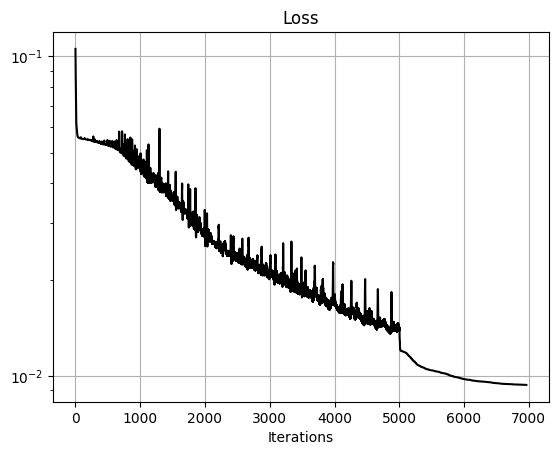

In [21]:
print (net.losses[-1], len(net.losses))
vis.plot_loss(net.losses)

In [22]:
try:
  del p
except NameError:
  None

In [23]:
net.model.eval()

Nx = 250
Ny = 250

x = torch.linspace(x_min, x_max, Nx).to(device)
y = torch.linspace(y_min, y_max, Ny).to(device)

mesh_XY = torch.stack(torch.meshgrid(x,y)).reshape(2, -1).T

X = torch.autograd.Variable(mesh_XY[:,0], requires_grad=True)
Y = torch.autograd.Variable(mesh_XY[:,1], requires_grad=True)

p = net.model([X,Y]).reshape(Nx, Ny).data.cpu().numpy().T

x = np.linspace(x_min, x_max, Nx)
y = np.linspace(y_min, y_max, Ny)

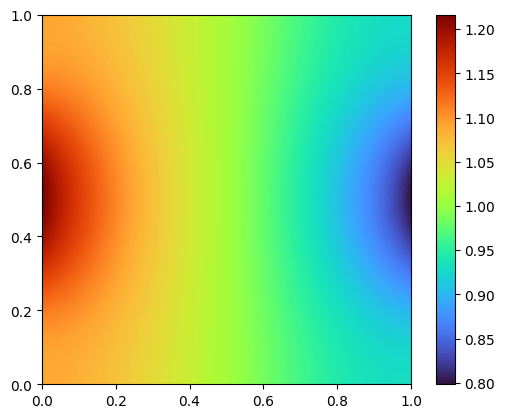

In [24]:
vis.plot(p, limits=[0,1,0,1])

-0.6788225099390858
-0.6788225173950195


<Axes: title={'center': 'Left'}>

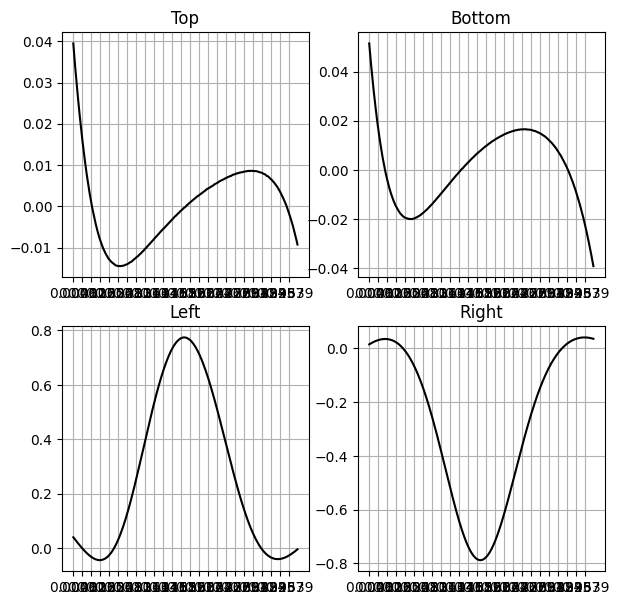

In [25]:
print (np.max(cond))
print (net.cond[0][2].min().item())

vis.plot_BC(p, x, y, L/(Nx-1), H/(Ny-1), [1,1,1,1])
plt.subplot(223)
# plt.plot(y, np.where(np.abs(y - np.max(y) / 2) <= chi / 2, net.cond[0][2].min().item(), 0), c='red', ls='--')